### Feature extraction, model training, Optimization and prediction

In [481]:
'''
Implemented features:
- katz:     Katz Fractal Dimension [2]
- svd:      SVD Entropy [3]
- higuchi:  Higuchi Fractal Dimension [3]
- petros:   Petrosian Fractal Dimension [3]
- zero:     Zero-Crossings (after signal normalization) [3]
- dfa:      Detrended Fluctuation Analysis
- bpm:      BPM (using peak detection)

References:
[1] Haugg, F., Elgendi, M., & Menon, C. (2023). GRGB rPPG: An Efficient Low-Complexity Remote Photoplethysmography-Based Algorithm for Heart Rate Estimation. Bioengineering (Basel, Switzerland), 10(2), 243. https://doi.org/10.3390/bioengineering10020243
[2] Boccignone G, Conte D, Cuculo V, D’Amelio A, Grossi G, Lanzarotti R, Mortara E. (2022). pyVHR: a Python framework for remote photoplethysmography. PeerJ Computer Science 8:e929 https://doi.org/10.7717/peerj-cs.929
[3] Boccignone, G., Bursic, S., Cuculo, V., D’Amelio, A., Grossi, G., Lanzarotti, R., & Patania, S. (2022). Deepfakes have no heart: A simple rppg-based method to reveal fake videos. In International Conference on Image Analysis and Processing (pp. 186-195). Springer International Publishing. https://doi.org/10.1007/978-3-031-06430-2_16

'''

'\nImplemented features:\n- katz:     Katz Fractal Dimension [2]\n- svd:      SVD Entropy [3]\n- higuchi:  Higuchi Fractal Dimension [3]\n- petros:   Petrosian Fractal Dimension [3]\n- zero:     Zero-Crossings (after signal normalization) [3]\n- dfa:      Detrended Fluctuation Analysis\n- bpm:      BPM (using peak detection)\n\nReferences:\n[1] Haugg, F., Elgendi, M., & Menon, C. (2023). GRGB rPPG: An Efficient Low-Complexity Remote Photoplethysmography-Based Algorithm for Heart Rate Estimation. Bioengineering (Basel, Switzerland), 10(2), 243. https://doi.org/10.3390/bioengineering10020243\n[2] Boccignone G, Conte D, Cuculo V, D’Amelio A, Grossi G, Lanzarotti R, Mortara E. (2022). pyVHR: a Python framework for remote photoplethysmography. PeerJ Computer Science 8:e929 https://doi.org/10.7717/peerj-cs.929\n[3] Boccignone, G., Bursic, S., Cuculo, V., D’Amelio, A., Grossi, G., Lanzarotti, R., & Patania, S. (2022). Deepfakes have no heart: A simple rppg-based method to reveal fake videos. 

In [ ]:
''' 
Selector: To select one of the datasets for feature extraction and training'''

from pathlib import Path

compression = 'raw'   # raw or c23 - compression type of the dataset
selector = 0
dataset_list = ['FaceShifter',          #0
                'NeuralTextures']       #1

# Set min video length to estimate features
min_length = 10     
# Define the folder path and file format (e.g., .csv)
main_path = 'dataset/FaceForensic++/' + dataset_list[selector]+f'/{compression}/'
folder_path = Path(main_path+'videos/')
csv_folder_path = main_path +'sig_csv/'

In [483]:
from pathlib import Path
import pandas as pd
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt
import numpy as np


# video statistics (e.g. FPS per video)
path_video_stats_manipulated = main_path + 'vid_fps.csv'
path_video_stats_original = 'dataset/FaceForensic++/original'+f'/{compression}/'+'vid_fps.csv'

# GRGB signal folders
path_GRGB_manipulated = csv_folder_path
path_GRGB_original = 'dataset/FaceForensic++/original' + f'/{compression}/' + 'sig_csv'

# Load the CSV file into a pandas DataFrame
stats_original = pd.read_csv(path_video_stats_original)
stats_manipulated = pd.read_csv(path_video_stats_manipulated)

def get_csvs(root_folder):
    csv_list = []
    root_path = Path(root_folder)
    
    # Use rglob to recursively find all CSV files
    for file_path in root_path.rglob('*.csv'):
        csv_list.append(str(file_path))  # Convert Path object to string
    
    return csv_list

#To extract filename
def extract_filename(file_path):
    # Create a Path object from the file path
    path = Path(file_path)
    # Extract the filename without extension
    return path.stem

#To extract fps values from the csv file
def get_fps(filename, df):
    filename = filename.strip()
    if filename in df['Filename'].values:
        fps_value = df.loc[df['Filename'] == filename, 'FPS'].values[0]
        return fps_value
    else:
        return None
    
#To extract fps values from the csv file
def get_fps2(filename, df):
    filename = int(filename.strip()) # INT
    if filename in df['Filename'].values:
        fps_value = df.loc[df['Filename'] == filename, 'FPS'].values[0]
        return fps_value
    else:
        return None
    
# BPM detection
def get_bpm_peaks(data, fps):
    peaks, _ = find_peaks(data, distance=fps/2)
    peak_intervals = np.diff(peaks) / fps
    heart_rate = 60.0 / np.mean(peak_intervals)
    return heart_rate


In [484]:
''' 
Function to compute Katz's Fractal Dimension (FD)
'''

import numpy as np
from pyVHR.extraction.utils import sig_windowing
import matplotlib.pyplot as plt

def katz_fd_(bvp_signal):

    if len(bvp_signal) < 2:
        return 0  # Not enough data to compute FD

    a = np.abs(np.mean(bvp_signal))  # Average of the signal points
    if a == 0:
        return 0  # Prevent division by zero in L/a and d/a

    L = np.sum(np.sqrt(np.diff(bvp_signal)**2 + 1))  # Total length of the time series
    d = np.max(np.abs(bvp_signal - bvp_signal[0]))  # Maximum distance from the first point
    # Katz's fractal dimension
    D_k = np.log10(L/a) / np.log10(d/a) if d != 0 else 0
   
    return D_k

# Function to calculate FD for a single patch across K windows
def compute_fd(bvp_windows, fps):
    #Transform the grgb signal to a 3d array
    sig = np.array(bvp_windows).reshape(len(bvp_windows),1,1)
    Ws = 3 # window length in seconds
    overlap = 1 # window overlap in seconds
    #fps = get_fps(videoFileName)
    windowed_sig, timesES = sig_windowing(sig, Ws, overlap, fps) 
    #Transform the windowed_sig to a bvp signal as np.ndarray with shape [num_estimators, num_frames]
    bvp = [arr.reshape(arr.shape[0], -1) for arr in windowed_sig]

    K = len(bvp)  # Number of time windows
    FD_sum = 0

    for k in range(K):  # Loop over K time windows
        FD_sum += katz_fd_(bvp[k][0])
    # Final FD for the single patch
    FD_patch = FD_sum / K
    return FD_patch


In [485]:
''' 
Compute the features for original dataset 
'''

import pandas as pd
import antropy as ant
from bpm_pyvhr import bpm_est
from bpm_welch import bpm_rppg_est
import nolds

df_original = pd.DataFrame(columns=['bpm', 'zero','svd','katz','dfa','higuchi','petros'])
csv_list_original = get_csvs(path_GRGB_original)

print(csv_list_original)

for i in csv_list_original:

    filename = extract_filename(i)
    try:
        rPPG_signal_raw = pd.read_csv(i, sep=',', header=None)
    except pd.errors.EmptyDataError:
        print(f"Excluded due to empty file: {filename}")
        continue

    rPPG_signal = rPPG_signal_raw.dropna()
    rPPG_signal = rPPG_signal_raw.iloc[:, 0].tolist()

    fps_vid = get_fps2(filename, stats_original)
    #print(fps_vid)
    
    if fps_vid is None:
        print(f"Excluded due to None FPS: {filename}")
        continue  # Skip this iteration if FPS is None
    
    if len(rPPG_signal) < min_length * fps_vid:
        print(f"Excluded due to small length: {filename}")
        continue
    else:
        rPPG_signal = rPPG_signal[0:int(min_length * fps_vid)]
    
    bpm_peaks_rppg = get_bpm_peaks(rPPG_signal, fps_vid)

    #df_original.loc[filename, 'filename'] = filename
    df_original.loc[filename, 'bpm'] = bpm_peaks_rppg
    #df_original.loc[filename, 'katz'] = ant.katz_fd(rPPG_signal)
    df_original.loc[filename, 'svd'] = ant.svd_entropy(rPPG_signal, normalize=True)
    df_original.loc[filename, 'dfa'] = ant.detrended_fluctuation(rPPG_signal)
    df_original.loc[filename, 'higuchi'] = ant.higuchi_fd(rPPG_signal)
    df_original.loc[filename, 'katz'] = compute_fd(rPPG_signal, fps_vid)
    df_original.loc[filename, 'petros'] = ant.petrosian_fd(rPPG_signal)
    
    rPPG_signal = (rPPG_signal - np.mean(rPPG_signal)) / np.std(rPPG_signal)
    df_original.loc[filename, 'zero'] = ant.num_zerocross(rPPG_signal)

['dataset\\FaceForensic++\\original\\raw\\sig_csv\\000.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\001.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\002.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\003.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\004.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\005.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\006.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\007.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\008.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\009.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\010.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\011.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\012.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\013.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\014.csv', 'dataset\\FaceForensic++\\original\\raw\\sig_csv\\015.csv', 'dataset\\FaceForensic++\\original\\raw

In [486]:
''' 
Compute the features for fake dataset 
'''

import pandas as pd
import antropy as ant
from bpm_pyvhr import bpm_est
from bpm_welch import bpm_rppg_est
import nolds

df_manipulated = pd.DataFrame(columns=['bpm', 'zero','svd','katz','dfa','higuchi','petros'])
#To retrieve all files with .csv format
csv_list_manipulated = get_csvs(path_GRGB_manipulated)

for i in csv_list_manipulated:
    filename = extract_filename(i)
    try:
        rPPG_signal_raw = pd.read_csv(i, sep=',', header=None)
    except pd.errors.EmptyDataError:
        print(f"Excluded due to empty file: {filename}")
        continue

    rPPG_signal = rPPG_signal_raw.dropna()
    rPPG_signal = rPPG_signal_raw.iloc[:, 0].tolist()
    
    fps_vid = get_fps(filename,stats_manipulated)

    if fps_vid is None:
        print(f"Excluded due to None FPS: {filename}")
        continue  # Skip this iteration if FPS is None
    
    if len(rPPG_signal) < min_length * fps_vid :
        print('Excluded due to small length:', filename)
        continue
    else:
        rPPG_signal = rPPG_signal[0:int(min_length * fps_vid)] 

    bpm_peaks_rppg = get_bpm_peaks(rPPG_signal, fps_vid)
 
    
    #df_manipulated.loc[filename, 'filename'] = filename
    df_manipulated.loc[filename, 'bpm'] = bpm_peaks_rppg
    #df_manipulated.loc[filename, 'katz'] = ant.katz_fd(rPPG_signal)
    df_manipulated.loc[filename, 'svd'] = ant.svd_entropy(rPPG_signal, normalize=True)
    df_manipulated.loc[filename, 'dfa'] = ant.detrended_fluctuation(rPPG_signal)
    df_manipulated.loc[filename, 'higuchi'] = ant.higuchi_fd(rPPG_signal)
    df_manipulated.loc[filename, 'katz'] = compute_fd(rPPG_signal, fps_vid)
    df_manipulated.loc[filename, 'petros'] = ant.petrosian_fd(rPPG_signal)
    
    rPPG_signal = (rPPG_signal - np.mean(rPPG_signal)) / np.std(rPPG_signal)
    df_manipulated.loc[filename, 'zero'] = ant.num_zerocross(rPPG_signal)


Excluded due to small length: 030_193
Excluded due to empty file: 096_101
Excluded due to small length: 105_180
Excluded due to small length: 156_243
Excluded due to small length: 174_964
Excluded due to small length: 192_134
Excluded due to empty file: 221_206
Excluded due to small length: 223_586
Excluded due to small length: 241_210
Excluded due to small length: 281_474
Excluded due to small length: 340_341
Excluded due to small length: 419_824
Excluded due to empty file: 427_637
Excluded due to empty file: 456_435
Excluded due to small length: 474_281
Excluded due to empty file: 491_226
Excluded due to small length: 500_592
Excluded due to empty file: 547_574
Excluded due to small length: 580_524
Excluded due to small length: 586_223
Excluded due to small length: 597_595
Excluded due to small length: 637_427
Excluded due to empty file: 647_622
Excluded due to small length: 664_668
Excluded due to small length: 739_865
Excluded due to small length: 744_674
Excluded due to empty file

In [487]:
''' 
DATASET UNDERSAMPLING
Truncates the longest dataset to the length of the shortest.

'''

print(f"{len(df_manipulated)} \t fakes")
print(f"{len(df_original)} \t original")

if len(df_manipulated) != len(df_original):
    smaller_length = min(len(df_manipulated), len(df_original))
    df_manipulated = df_manipulated[:smaller_length]
    df_original = df_original[:smaller_length]

    print("\n truncated data:")
    print(f"{len(df_manipulated)} \t fakes")
    print(f"{len(df_original)} \t original")

965 	 fakes
967 	 original

 truncated data:
965 	 fakes
965 	 original


In [488]:
# Assign the label column using .loc to avoid the warning
df_original['label'] = 'original'   # original
df_manipulated['label'] = 'fake'  # fake
# Combine the DataFrames
df_combined = pd.concat([df_original, df_manipulated], ignore_index=True)
df_combined

,bpm,zero,svd,katz,dfa,higuchi,petros,label
0,88.983051,31,0.010219,-0.807784,1.217238,1.620498,1.033631,original
1,87.136929,29,0.011046,-0.813006,1.419655,1.443169,1.031815,original
2,86.896552,38,0.008741,-0.827381,1.339097,1.544042,1.038376,original
3,82.978723,33,0.014767,-0.781104,1.212098,1.615666,1.035179,original
4,76.595745,72,0.014858,-0.801452,1.052276,1.874208,1.047792,original
...,...,...,...,...,...,...,...,...
1925,88.732394,42,0.015796,-0.935873,1.327699,1.669613,1.035505,fake
1926,79.591837,54,0.027516,-0.927337,1.112548,1.723812,1.036976,fake
1927,82.627119,33,0.033182,-1.073927,1.241415,1.616818,1.040791,fake
1928,89.679715,48,0.020788,-0.957809,1.368576,1.734692,1.042633,fake


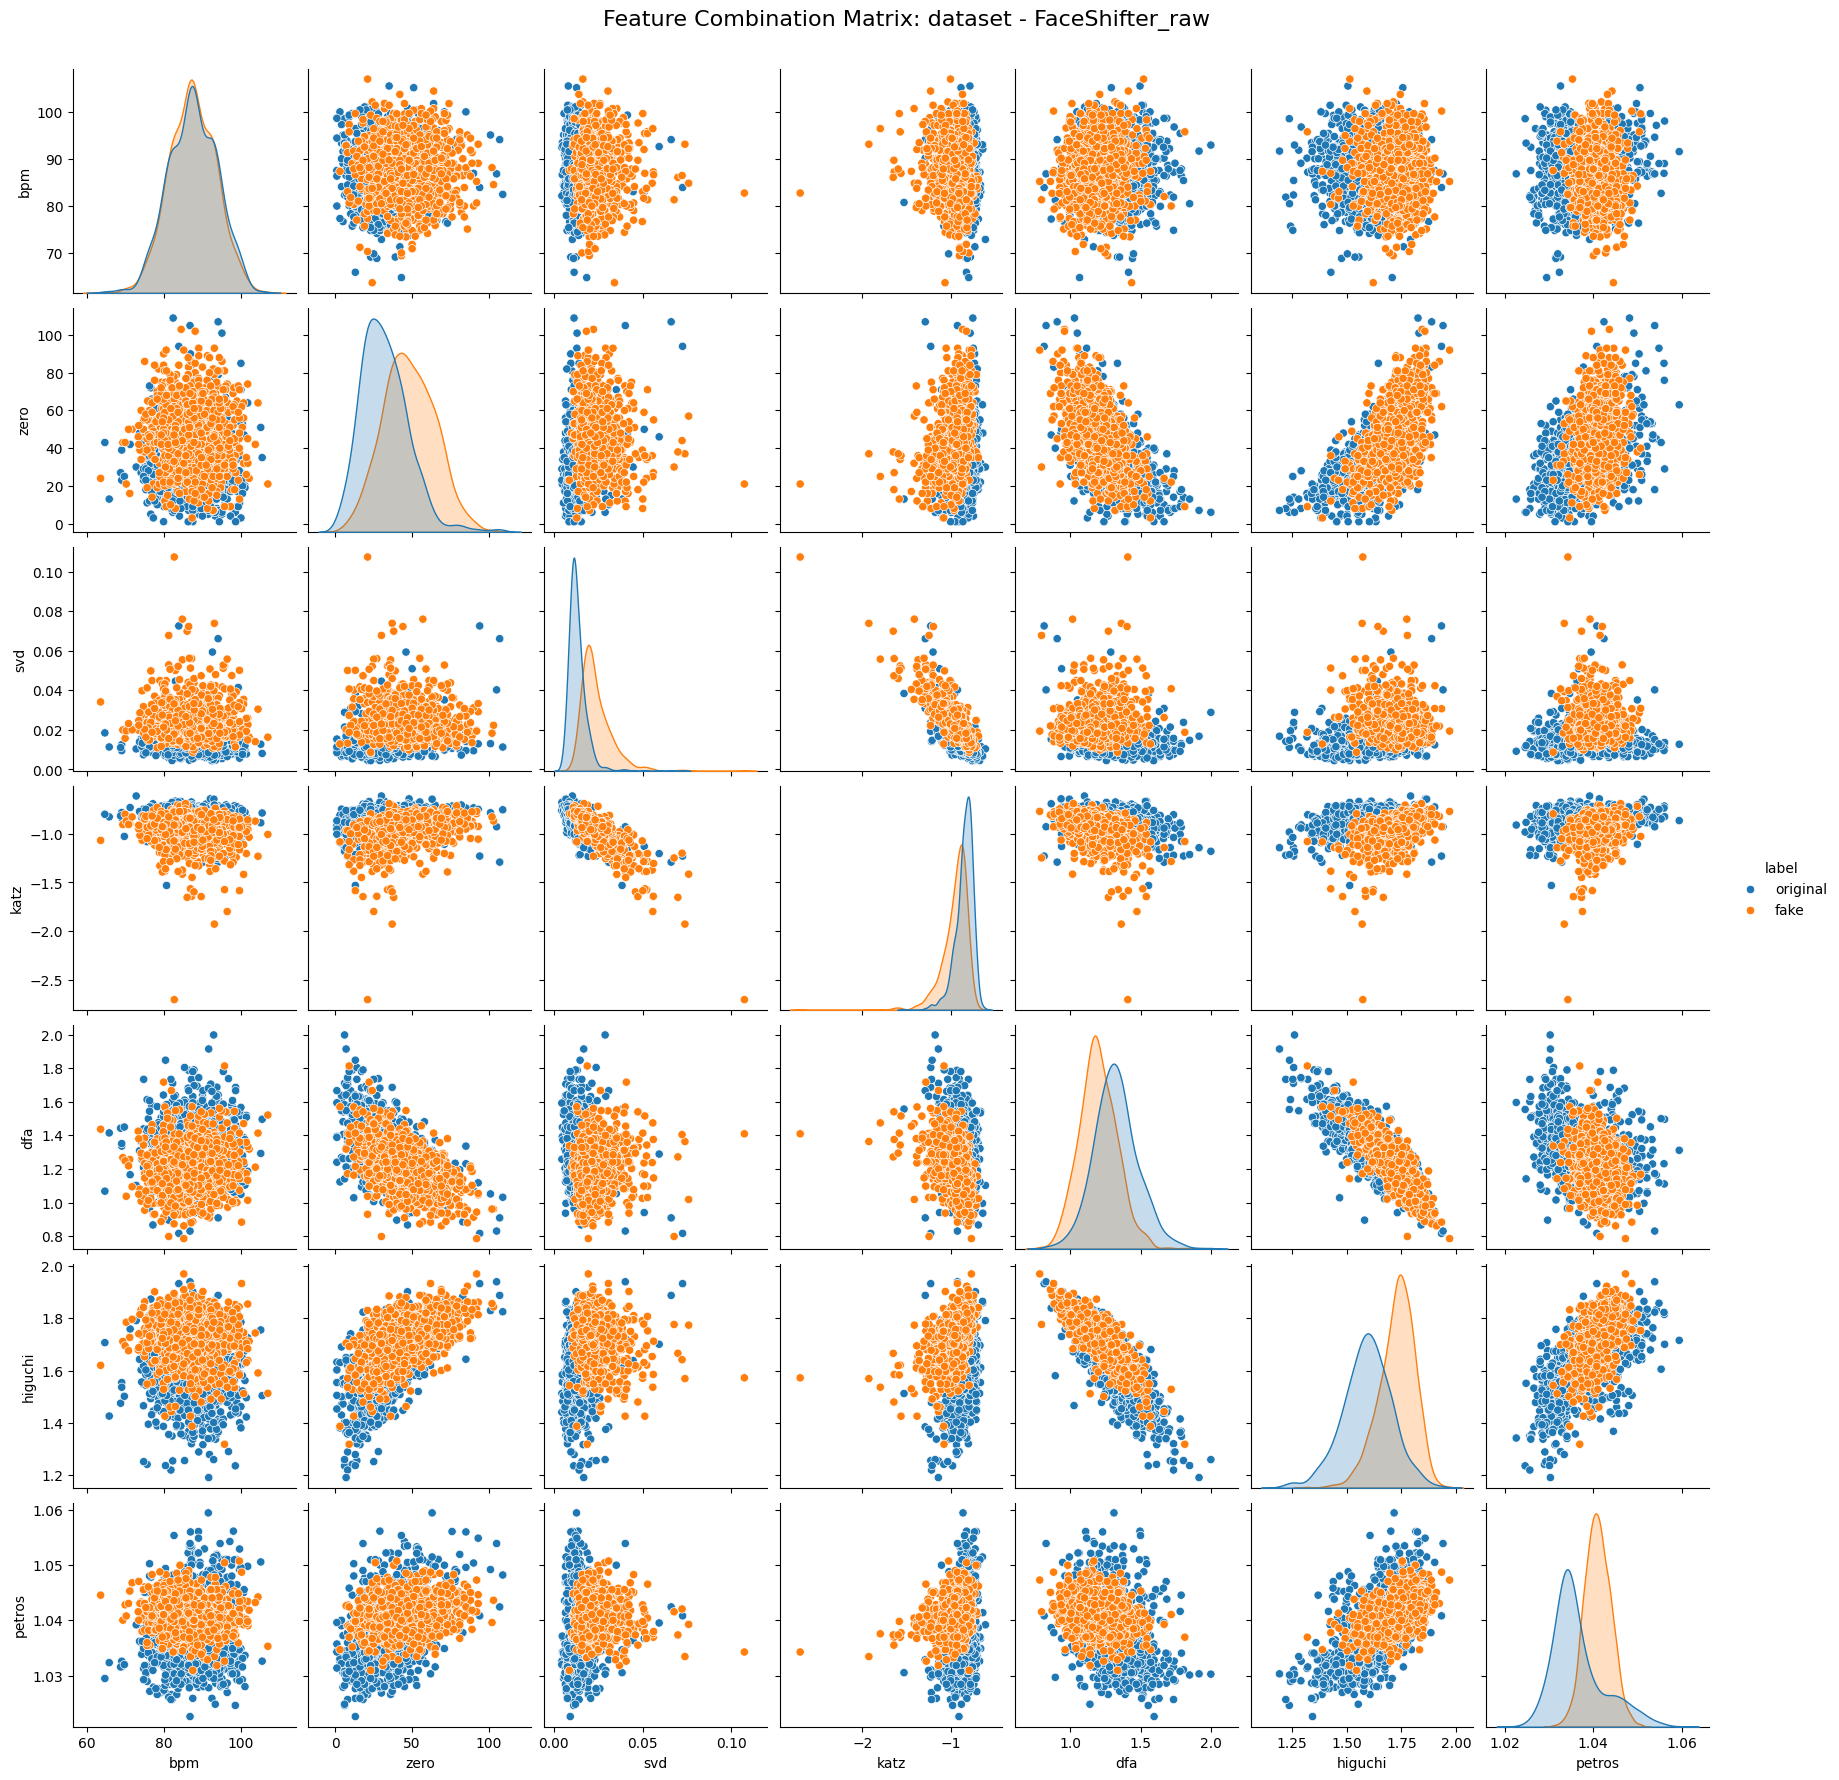

In [489]:
'''Feature combination Matrix'''
import seaborn as sns
import matplotlib.pyplot as plt
# Ensure plots display inline in Jupyter Notebook
%matplotlib inline

# Load your DataFrame (assuming df is the DataFrame and 'target' is the target column)
# sns.pairplot will handle only numerical columns, so exclude any non-numeric data or target if you have it
pairplot_df = df_combined.drop(columns=['label'])  # Adjust 'target' as needed

# Pair plot with color encoding for the target variable if present
sns.pairplot(df_combined, hue='label') 
plt.suptitle(f"Feature Combination Matrix: dataset - {dataset_list[selector]}_{compression} ", y=1.02, fontsize=16)

# Display the plot
plt.show()

### Model training and feature selection

In [490]:
''' 
INITIAL MODEL TRAINING AND PREDICTION 
Test accuracy with feature normalization and standard parameters
'''
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X = df_combined.drop('label', axis=1) # All features
y = df_combined['label']  # Target labels

scaler = StandardScaler()
X = scaler.fit_transform(X)

# split dataset into training and testing sets, ratio: 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = SVC(kernel='linear')
model.fit(X_train, y_train)

# evaluate model on the test set
accuracy = model.score(X_test, y_test)
print("Test accuracy with feature normalization and standard parameters:")
print(f"test accuracy for {dataset_list[selector]}_{compression}: {accuracy:.2f}")
print(f"percentage: {accuracy * 100:.2f}%".replace('.', ',') )

Test accuracy with feature normalization and standard parameters:
test accuracy for FaceShifter_raw: 0.88
percentage: 88,43%


In [491]:
''' 
FEATURE SELECTION:
Measures how much each feature contributes to the model's decision boundary.
For linear SVM models – model-based coefficients

'''
feature_names = df_combined.columns.tolist()  # Convert column names to a list

# ensure model has a linear kernel (since coef_ only works for linear kernels)
if hasattr(model, 'coef_'):
    # extract feature importance (weights of the linear SVM)
    feature_importance = np.abs(model.coef_[0])

    # pair feature importance with feature names
    feature_importance_with_names = sorted(zip(feature_importance, feature_names), reverse=True)

    # display sorted feature importance
    print("Feature importance for model:\n")
    for importance, name in feature_importance_with_names:
        print(f"{importance:.2f} \t {name}")
else:
    raise AttributeError("The model does not support feature importance extraction (only works for linear kernels).")

Feature importance for model:

1.77 	 higuchi
1.41 	 svd
0.65 	 dfa
0.51 	 katz
0.31 	 zero
0.14 	 petros
0.07 	 bpm


In [492]:
''' 
FEATURE SELECTION:
Measures the statistical significance of each feature's relationship with the target label.
For all model types – uses ANOVA

'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import f_classif
import pandas as pd

X = df_combined.drop('label', axis=1)  # All features
Y = df_combined['label']  # Target labels

# feature extraction
test = SelectKBest(score_func=f_classif, k='all')
fit = test.fit(X, Y)

fsr = pd.DataFrame({'feature': X.columns, 'score': fit.scores_})
fsr_sorted = fsr.sort_values(by='score', ascending=False)

print("Feature – General Statistical Significance:\n")
for _, row in fsr_sorted.iterrows():
    print(f"{row['score']:.2f} \t {row['feature']}")

Feature – General Statistical Significance:

971.89 	 svd
898.57 	 higuchi
453.35 	 zero
443.90 	 petros
352.66 	 dfa
318.04 	 katz
0.28 	 bpm


In [493]:
''' 
FEATURE SELECTION:
Measures the statistical significance of each feature's relationship with the target label.
Recursive Feature Elimination (RFE) method

'''
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
import pandas as pd

# Assuming df is your DataFrame and 'label' is your target variable
X = df_combined.drop('label', axis=1)
Y = df_combined['label']

# Initialize a Support Vector Classifier
model = SVC(kernel='linear')  # Use a linear kernel for RFE

# Create RFE model and select attributes
rfe = RFE(estimator=model, n_features_to_select=5)  # Select the top 5 features
fit = rfe.fit(X, Y)

# Create a DataFrame for feature rankings
rfe_results = pd.DataFrame({'feature': X.columns, 'ranking': fit.ranking_})
rfe_sorted = rfe_results.sort_values(by='ranking')

print("RFE Feature Ranking:\n")
print(rfe_sorted)


RFE Feature Ranking:

   feature  ranking
2      svd        1
3     katz        1
4      dfa        1
5  higuchi        1
6   petros        1
1     zero        2
0      bpm        3


In [494]:
''' 
FEATURE SELECTION:
Measures the statistical significance of each feature's relationship with the target label.
Tree-based Feature Importance

'''

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Assuming df is your DataFrame and 'label' is your target variable
X = df_combined.drop('label', axis=1)
Y = df_combined['label']

# Initialize Random Forest model
model = RandomForestClassifier()

# Fit the model
model.fit(X, Y)

# Get feature importances
importances = model.feature_importances_

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({'feature': X.columns, 'importance': importances})
importance_sorted = importance_df.sort_values(by='importance', ascending=False)

print("Random Forest Feature Importance:\n")
print(importance_sorted)


Random Forest Feature Importance:

   feature  importance
2      svd    0.382215
6   petros    0.234168
5  higuchi    0.135423
3     katz    0.097010
4      dfa    0.062654
1     zero    0.058180
0      bpm    0.030350


In [495]:
''' 
INITIAL MODEL TRAINING AND PREDICTION  – 10 CV
'''

from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler


X = df_combined.drop('label', axis=1) # All features
y = df_combined['label']  # Target labels

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

model = SVC(kernel='linear')
model.fit(X_train, y_train)

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # standardize
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # train
    model = SVC(kernel='rbf') #SVC(kernel='linear', C=0.1, gamma='scale')
    model.fit(X_train, y_train)
    
    # test
    y_pred = model.predict(X_test)
    
    # evaluate
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

# Output the accuracies for each fold
print("Initial accuracy (standard parameters, feature normalization):\n")
print(f"dataset : {dataset_list[selector]}_{compression}")
print("accuracies for each fold:", fold_accuracies)
mean_fold_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"mean accuracy across folds: {mean_fold_accuracy:.2}")
print(f"percentage: {mean_fold_accuracy * 100:.2f}%".replace('.', ',') )
mean_fold_accuracy_std = np.std(fold_accuracies)
print(f"std: {mean_fold_accuracy_std :.2f}".replace('.', ',') )

accuracy_initial = mean_fold_accuracy 

Initial accuracy (standard parameters, feature normalization):

dataset : FaceShifter_raw
accuracies for each fold: [0.927461139896373, 0.9430051813471503, 0.9481865284974094, 0.9430051813471503, 0.9326424870466321, 0.9430051813471503, 0.9378238341968912, 0.9067357512953368, 0.927461139896373, 0.9067357512953368]
mean accuracy across folds: 0.93
percentage: 93,16%
std: 0,01


### Optimization

In [ ]:
# ''' 
# HYPERPARAMETER OPTIMIZATION
# (Calculation might take a long time, depending on the data size!)
# '''

# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'C': [0.001, 0.1, 1, 10, 100],     # regularization parameter
#     'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],  # kernel coefficient #
#     'kernel': ['linear','rbf','sigmoid','poly'] 
# }

# optimal_params = GridSearchCV(
#     SVC(),
#     param_grid,
#     cv=10,
#     scoring='accuracy'
# )

# print(f"dataset : {dataset_list[selector]}_{compression}")
# optimal_params.fit(X_train,y_train)
# print(f"parameters : {optimal_params.best_params_}")
# accuracy = model.score(X_test, y_test)
# print(f"accuracy: {accuracy:.2f}")
# print(f"percentage: {accuracy * 100:.2f}%".replace('.', ',') )


dataset : FaceShifter_raw
parameters : {'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}
accuracy: 0.91
percentage: 90,67%


In [543]:
''' 
OPTIMIZED TRAINING on selected hyperparameters and features
Features selected based on the results from ANOVA, RFE, Random Forest
'''

X = df_combined[['higuchi', 'svd', 'petros','katz','dfa', 'zero']] # Specific features
y = df_combined['label']  # Target labels

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Optimized Hpyerparameters
p_kernel = 'rbf'
p_C = 1   #100
p_gamma = 'auto'  #0.01

model = SVC(kernel=p_kernel, C=p_C, gamma=p_gamma)
model.fit(X_train, y_train)

accuracy = model.score(X_test, y_test)
print(f"test accuracy for {dataset_list[selector]}_{compression}: {accuracy:.2f}")
print(f"percentage: {accuracy * 100:.2f}%".replace('.', ',') )

test accuracy for FaceShifter_raw: 0.91
percentage: 90,50%


In [544]:
''' 
TEST FOR OVERFITTING: 
'''

from sklearn.metrics import accuracy_score

# predictions on training and test sets
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# accuracy for training and test sets
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"{train_accuracy:.4f} \t train accuracy")
print(f"{test_accuracy:.4f} \t test accuracy")
print(f"{abs(test_accuracy-train_accuracy):.4f} \t abs. difference")

0.9526 	 train accuracy
0.9050 	 test accuracy
0.0476 	 abs. difference


In [545]:
''' 
CONFUSION MATRIX 
'''
from sklearn.metrics import confusion_matrix

svm_predicted = model.predict(X_test)
confusion = confusion_matrix(y_test, svm_predicted,labels=['fake', 'original'])
print(confusion)

confusion_percentage = confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis] * 100
print("\n ———percentage——— \n")
print(np.round(confusion_percentage, 2))

[[272  20]
 [ 35 252]]

 ———percentage——— 

[[93.15  6.85]
 [12.2  87.8 ]]


In [546]:
''' 
EVALUATION METRICS
- Precision: Measures how many instances predicted as "original" are actually "original."
- Recall: Measures how many of the actual "original" instances are correctly identified.
- F1 Score: Indicates balance between precision and recall

'''

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Function to evaluate the model and interpret the results
def evaluate_model(y_test, svm_predicted, labels=['manipulated', 'original']):
    confusion = confusion_matrix(y_test, svm_predicted, labels=labels)    

    precision = precision_score(y_test, svm_predicted, pos_label='original')
    recall = recall_score(y_test, svm_predicted, pos_label='original')
    f1 = f1_score(y_test, svm_predicted, pos_label='original')
    
    print("\nEvaluation Metrics:")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
svm_predicted = model.predict(X_test)
evaluate_model(y_test, svm_predicted, labels=['manipulated', 'original'])



Evaluation Metrics:
Precision: 0.93
Recall: 0.88
F1 Score: 0.90


In [547]:
''' 
OPTIMIZED TRAINING = 10CV
'''
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_accuracies = []

# Perform 10-fold cross-validation
for train_index, test_index in kf.split(X, y):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    model = SVC(kernel=p_kernel, C=p_C, gamma=p_gamma)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracies.append(accuracy)

print("Optimized accuracy \n")
print(f"dataset : {dataset_list[selector]}")
print("accuracies for each fold:", fold_accuracies)
mean_fold_accuracy = sum(fold_accuracies) / len(fold_accuracies)
print(f"mean accuracy across folds: {mean_fold_accuracy:.2}")
print(f"percentage: {mean_fold_accuracy * 100:.2f}%".replace('.', ',') )
mean_fold_accuracy_std = np.std(fold_accuracies)
print(f"std: {mean_fold_accuracy_std :.2f}".replace('.', ',') )
accuracy_optimized = mean_fold_accuracy 


Optimized accuracy 

dataset : FaceShifter
accuracies for each fold: [0.917098445595855, 0.9533678756476683, 0.9430051813471503, 0.9430051813471503, 0.9326424870466321, 0.9430051813471503, 0.9378238341968912, 0.917098445595855, 0.9222797927461139, 0.9067357512953368]
mean accuracy across folds: 0.93
percentage: 93,16%
std: 0,01


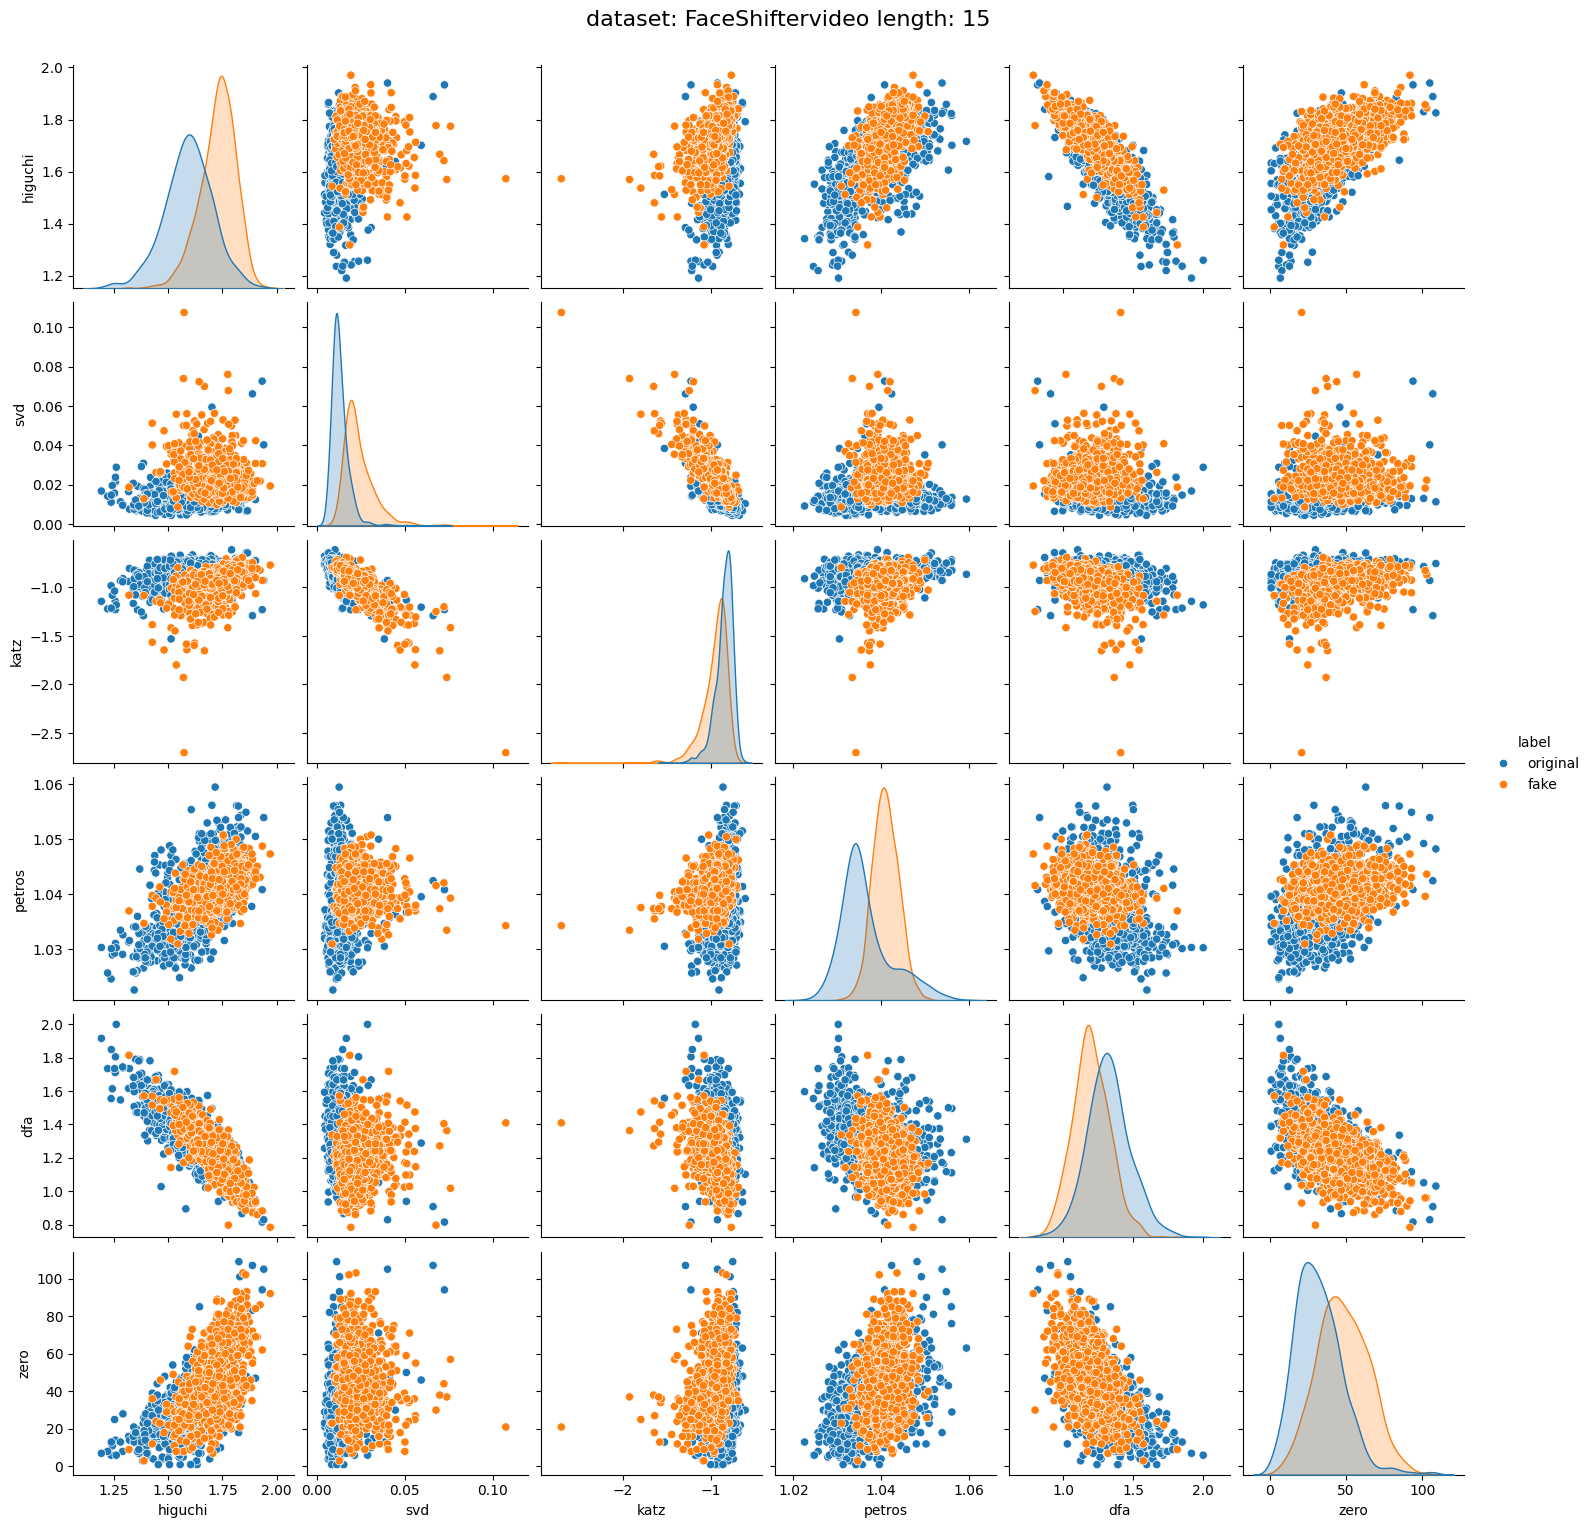

In [511]:
''' 
OPTIMIZED FEATURES: MATRIX
'''

features_to_include = ['higuchi', 'svd', 'katz', 'petros', 'dfa', 'zero']

df_subset = df_combined[features_to_include + ['label']] 

g = sns.pairplot(df_subset, hue='label')
g.fig.suptitle(f"dataset: {dataset_list[selector]}video length: {15}", y=1.02, fontsize=16)
plt.show()

In [528]:
''' 
RESULTS
'''
print(f"dataset : {dataset_list[selector]}")
print('length of datasets:',len(df_original), 'originals ,',len(df_manipulated), 'fakes')
print(f"duration : {min_length} seconds \n")
print(f"initial accuracy: \t {accuracy_initial* 100:.2f}".replace('.', ','))
print(f"optimized accuracy: \t {accuracy_optimized* 100:.2f}".replace('.', ','))


dataset : FaceShifter
length of datasets: 965 originals , 965 fakes
duration : 10 seconds 

initial accuracy: 	 93,16
optimized accuracy: 	 92,85
